In [1]:
!pip install fastparquet
!pip install workalendar

     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for fastparquet: filename=fastparquet-0.3.3-cp36-cp36m-linux_x86_64.whl size=253304 sha256=f7bcc6523aa403214d99786368ed05f10b16996555e14ea97f1c1b45c7fafc5e
  Stored in directory: /root/.cache/pip/wheels/a0/27/9f/d8066bbbbb77e97d8ad3daf4de155ead73693bc4aa2f52098c
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=345234 sha256=54271cdb5fe2d8c558bc37b7257b8146679ccf79e5972939f9df1078c82d5181
  Stored in directory: /root/.cache/pip/wheels/02/a2/46/689ccfcf40155c23edc7cdbd9de488611c8fdf49ff34b1706e
Successfully built fastparquet thrift
     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 266kB 48.3MB/s 
     |████████████████████████████████| 16.0MB 307kB/s 
     |████████████████████████████████| 245kB 48.1MB/s 
  Created wheel for skyfield: filename=skyfield-1.20-cp36-none-any.whl size=29737

just want more ram...

In [0]:
# a = []
# while(1):
#     a.append('1')

## Setting & Import packages

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import os
import gc
import re
import csv
import time
import fastparquet
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


from time import time
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Embedding, concatenate, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras import backend as K
from keras.utils import plot_model
from tqdm.notebook import tqdm_notebook as tqdm
from workalendar import usa
from datetime import datetime
from hyperopt import STATUS_OK
#from catboost import CatBoostRegressor, Pool

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
drive.mount('/melissakou', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /melissakou


In [0]:
os.chdir('/melissakou/My Drive/Colab Notebooks/m5')

In [0]:
sales = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')

In [0]:
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')

In [0]:
prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')

## Preprocessing

### calendar

In [0]:
calendar[['event_name_1', 'event_type_1']] = calendar[['event_name_1', 'event_type_1']].fillna('0')
calendar['day'] = calendar['date'].str[-2:]
calendar['day'] = LabelEncoder().fit_transform(calendar['day'])
calendar['week_of_year'] = calendar['wm_yr_wk'].astype('str').str[-2:]
calendar['week_of_year'] = LabelEncoder().fit_transform(calendar['week_of_year'])
calendar['d'] = calendar.d.str[2:].astype('int')
calendar['event_name_1'] = LabelEncoder().fit_transform(calendar['event_name_1'])
calendar['event_type_1'] = LabelEncoder().fit_transform(calendar['event_type_1'])
calendar['wday'] = calendar['wday'] - 1
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day,week_of_year
0,2011-01-29,11101,Saturday,0,1,2011,1,0,0,NaN,NaN,0,0,0,28,0
1,2011-01-30,11101,Sunday,1,1,2011,2,0,0,NaN,NaN,0,0,0,29,0
2,2011-01-31,11101,Monday,2,1,2011,3,0,0,NaN,NaN,0,0,0,30,0
3,2011-02-01,11101,Tuesday,3,2,2011,4,0,0,NaN,NaN,1,1,0,0,0
4,2011-02-02,11101,Wednesday,4,2,2011,5,0,0,NaN,NaN,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,4,6,2016,1965,0,0,NaN,NaN,0,1,1,14,19
1965,2016-06-16,11620,Thursday,5,6,2016,1966,0,0,NaN,NaN,0,0,0,15,19
1966,2016-06-17,11620,Friday,6,6,2016,1967,0,0,NaN,NaN,0,0,0,16,19
1967,2016-06-18,11621,Saturday,0,6,2016,1968,0,0,NaN,NaN,0,0,0,17,20


In [0]:
calendar['date'] = pd.to_datetime(calendar['date'], format = "%Y-%m-%d")

In [0]:
cal_CA = usa.California()
cal_TX = usa.Texas()
cal_WI = usa.Wisconsin()

In [0]:
calendar['working_day_CA'] = calendar['date'].apply(cal_CA.is_working_day).astype('int')
calendar['working_day_TX'] = calendar['date'].apply(cal_TX.is_working_day).astype('int')
calendar['working_day_WI'] = calendar['date'].apply(cal_WI.is_working_day).astype('int')

In [0]:
calendar = calendar.drop(columns = ['date', 'weekday', 'event_name_2', 'event_type_2'])

In [0]:
calendar

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,day,week_of_year,working_day_CA,working_day_TX,working_day_WI
0,11101,0,1,2011,1,0,0,0,0,0,28,0,0,0,0
1,11101,1,1,2011,2,0,0,0,0,0,29,0,0,0,0
2,11101,2,1,2011,3,0,0,0,0,0,30,0,1,1,1
3,11101,3,2,2011,4,0,0,1,1,0,0,0,1,1,1
4,11101,4,2,2011,5,0,0,1,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,11620,4,6,2016,1965,0,0,0,1,1,14,19,1,1,1
1965,11620,5,6,2016,1966,0,0,0,0,0,15,19,1,1,1
1966,11620,6,6,2016,1967,0,0,0,0,0,16,19,1,1,1
1967,11621,0,6,2016,1968,0,0,0,0,0,17,20,0,0,0


In [0]:
melt_snap = calendar.melt(id_vars = ['d'],  value_vars = ['snap_CA', 'snap_TX', 'snap_WI'],
                          var_name = 'state_id', value_name = 'snap')
melt_snap['state_id'] = [re.sub('snap_', '', x) for x in melt_snap['state_id']]
melt_working = calendar.melt(id_vars = ['d'],  value_vars = ['working_day_CA', 'working_day_TX', 'working_day_WI'],
                             var_name = 'state_id', value_name = 'working_day')
melt_working['state_id'] = [re.sub('working_day_', '', x) for x in melt_snap['state_id']]
calendar = pd.merge(calendar, melt_snap, how = 'inner', on = 'd')
calendar = pd.merge(calendar, melt_working, how = 'inner', on = ['d', 'state_id'])
calendar = calendar.drop(columns = ['snap_CA', 'snap_TX', 'snap_WI', 'working_day_CA', 'working_day_TX', 'working_day_WI'])
calendar['state_id'] = LabelEncoder().fit_transform(calendar['state_id'])
calendar

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,day,week_of_year,state_id,snap,working_day
0,11101,0,1,2011,1,0,0,28,0,0,0,0
1,11101,0,1,2011,1,0,0,28,0,1,0,0
2,11101,0,1,2011,1,0,0,28,0,2,0,0
3,11101,1,1,2011,2,0,0,29,0,0,0,0
4,11101,1,1,2011,2,0,0,29,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5902,11621,0,6,2016,1968,0,0,17,20,1,0,0
5903,11621,0,6,2016,1968,0,0,17,20,2,0,0
5904,11621,1,6,2016,1969,17,4,18,20,0,0,0
5905,11621,1,6,2016,1969,17,4,18,20,1,0,0


### prices

In [0]:
gr = prices.groupby(["store_id", "item_id"])["sell_price"]
prices['price_pct_change'] = (prices['sell_price'] - gr.transform(lambda x: x.shift(7))) / gr.transform(lambda x: x.shift(7))
prices['price_discount'] = prices['sell_price'] / gr.cummax()
prices['price_roll_std_7'] = gr.transform(lambda x: x.rolling(30).std())
prices['store_id'] = LabelEncoder().fit_transform(prices['store_id'])
prices['item_id'] = LabelEncoder().fit_transform(prices['item_id'])
del gr
gc.collect()

prices

0

,store_id,item_id,wm_yr_wk,sell_price,price_pct_change,price_discount,price_roll_std_7
0,0,1437,11325,9.58,NaN,1.000000,NaN
1,0,1437,11326,9.58,NaN,1.000000,NaN
2,0,1437,11327,8.26,NaN,0.862213,NaN
3,0,1437,11328,8.26,NaN,0.862213,NaN
4,0,1437,11329,8.26,NaN,0.862213,NaN
...,...,...,...,...,...,...,...
6841116,9,1436,11617,1.00,0.0,1.000000,0.0
6841117,9,1436,11618,1.00,0.0,1.000000,0.0
6841118,9,1436,11619,1.00,0.0,1.000000,0.0
6841119,9,1436,11620,1.00,0.0,1.000000,0.0


### sales

In [0]:
drop = 1000
sales = sales.drop(columns = ["d_" + str(i+1) for i in range(drop-1)])
sales = sales.reindex(columns = sales.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])

In [0]:
sales['item_store'] = sales['item_id'] + '_' + sales['store_id']

In [0]:
cat_var = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'item_store']
for v in cat_var:
    sales[v] = LabelEncoder().fit_transform(sales[v])

In [0]:
sales = sales.melt(id_vars=["id", 'item_store', "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                   var_name='d', value_name='demand')
gc.collect()

0

In [0]:
sales

,id,item_store,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,14370,1437,3,1,0,0,d_1000,0.0
1,HOBBIES_1_002_CA_1_validation,14380,1438,3,1,0,0,d_1000,0.0
2,HOBBIES_1_003_CA_1_validation,14390,1439,3,1,0,0,d_1000,0.0
3,HOBBIES_1_004_CA_1_validation,14400,1440,3,1,0,0,d_1000,1.0
4,HOBBIES_1_005_CA_1_validation,14410,1441,3,1,0,0,d_1000,1.0
...,...,...,...,...,...,...,...,...,...
29575295,FOODS_3_823_WI_3_validation,14329,1432,2,0,9,2,d_1969,NaN
29575296,FOODS_3_824_WI_3_validation,14339,1433,2,0,9,2,d_1969,NaN
29575297,FOODS_3_825_WI_3_validation,14349,1434,2,0,9,2,d_1969,NaN
29575298,FOODS_3_826_WI_3_validation,14359,1435,2,0,9,2,d_1969,NaN


In [0]:
gr = sales.groupby(['id'])['demand']
print('Creating Features:')

print('demand_lag_1')
sales['demand_lag_1'] = gr.transform(lambda x: x.shift(1))

print('demand_lag_2')
sales['demand_lag_2'] = gr.transform(lambda x: x.shift(2))

print('demand_lag_3')
sales['demand_lag_3'] = gr.transform(lambda x: x.shift(3))

print('demand_lag_4')
sales['demand_lag_4'] = gr.transform(lambda x: x.shift(4))

print('demand_lag_5')
sales['demand_lag_5'] = gr.transform(lambda x: x.shift(5))

print('demand_lag_6')
sales['demand_lag_6'] = gr.transform(lambda x: x.shift(6))

print('demand_lag_7')
sales['demand_lag_7'] = gr.transform(lambda x: x.shift(7))

print('demand_lag_14')
sales['demand_lag_14'] = gr.transform(lambda x: x.shift(14))

print('demand_lag_21')
sales['demand_lag_21'] = gr.transform(lambda x: x.shift(21))

print('demand_lag_28')
sales['demand_lag_28'] = gr.transform(lambda x: x.shift(28))

print('demand_lag_365')
sales['demand_lag_365'] = gr.transform(lambda x: x.shift(365))

print('demand_lag_365_roll_mean')
sales['demand_lag_365_roll_mean'] = gr.transform(lambda x: x.shift(365).rolling(5, center = True).mean())

print('demand_lag_365_roll_max')
sales['demand_lag_365_roll_max'] = gr.transform(lambda x: x.shift(365).rolling(5, center = True).max())

print('demand_lag_365_roll_min')
sales['demand_lag_365_roll_min'] = gr.transform(lambda x: x.shift(365).rolling(5, center = True).min())

print('demand_roll_mean_7')
sales['demand_roll_mean_7'] = gr.transform(lambda x: x.shift(1).rolling(7).mean())

print('demand_roll_mean_28')
sales['demand_roll_mean_28'] = gr.transform(lambda x: x.shift(1).rolling(28).mean())

print('demand_roll_mean_60')
sales['demand_roll_mean_60'] = gr.transform(lambda x: x.shift(1).rolling(60).mean())

print('demand_roll_mean_90')
sales['demand_roll_mean_90'] = gr.transform(lambda x: x.shift(1).rolling(90).mean())

print('demand_roll_mean_180')
sales['demand_roll_mean_180'] = gr.transform(lambda x: x.shift(1).rolling(180).mean())

print('demand_roll_std_7')
sales['demand_roll_std_7'] = gr.transform(lambda x: x.shift(1).rolling(7).std())

print('demand_roll_std_28')
sales['demand_roll_std_28'] = gr.transform(lambda x: x.shift(1).rolling(28).mean())

del gr
gc.collect()

sales['d'] = sales.d.str[2:].astype('int')
gc.collect()
sales = sales[(sales.d >= 1914) | (pd.notna(sales.demand_lag_365_roll_mean))]
sales.head()
sales.shape
gc.collect()

Creating Features:
demand_lag_1
demand_lag_2
demand_lag_3
demand_lag_4
demand_lag_5
demand_lag_6
demand_lag_7
demand_lag_14
demand_lag_21
demand_lag_28
demand_lag_365
demand_lag_365_roll_mean
demand_lag_365_roll_max
demand_lag_365_roll_min
demand_roll_mean_7
demand_roll_mean_28
demand_roll_mean_60
demand_roll_mean_90
demand_roll_mean_180
demand_roll_std_7
demand_roll_std_28


0

11

,id,item_store,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,demand_lag_14,demand_lag_21,demand_lag_28,demand_lag_365,demand_lag_365_roll_mean,demand_lag_365_roll_max,demand_lag_365_roll_min,demand_roll_mean_7,demand_roll_mean_28,demand_roll_mean_60,demand_roll_mean_90,demand_roll_mean_180,demand_roll_std_7,demand_roll_std_28
11189830,HOBBIES_1_001_CA_1_validation,14370,1437,3,1,0,0,1367,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.428571,0.571429,0.600000,0.566667,0.511111,0.534522,0.571429
11189831,HOBBIES_1_002_CA_1_validation,14380,1438,3,1,0,0,1367,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.2,1.0,0.0,0.428571,0.392857,0.283333,0.311111,0.366667,0.786796,0.392857
11189832,HOBBIES_1_003_CA_1_validation,14390,1439,3,1,0,0,1367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.071429,0.150000,0.122222,0.150000,0.000000,0.071429
11189833,HOBBIES_1_004_CA_1_validation,14400,1440,3,1,0,0,1367,6.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,3.0,0.0,8.0,3.6,8.0,0.0,0.857143,1.428571,1.866667,1.988889,2.272222,1.463850,1.428571
11189834,HOBBIES_1_005_CA_1_validation,14410,1441,3,1,0,0,1367,1.0,6.0,2.0,1.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,1.0,0.6,1.0,0.0,2.142857,1.428571,1.083333,0.977778,0.894444,2.734262,1.428571


(18385470, 30)

0

### merge data

In [0]:
prices['store_id'] = LabelEncoder().fit_transform(prices['store_id'])
prices['item_id'] = LabelEncoder().fit_transform(prices['item_id'])

In [0]:
sales = pd.merge(sales, calendar, how = 'left', on = ['d', 'state_id'])
del calendar
gc.collect()
sales = pd.merge(sales, prices, how = "left", on = ["store_id", "item_id", "wm_yr_wk"])
del prices
gc.collect()

28

0

In [0]:
gc.collect()

0

In [0]:
sales['year'] = sales['year'] - 2014
sales['month'] = sales['month'] - 1

In [0]:
# sales.to_parquet('sales_0430.gzip.parquet',compression='gzip')

In [0]:
# del sales
# gc.collect()

0

In [6]:
sales = pd.read_parquet('sales_0430.gzip.parquet')
gc.collect()

3

## Categorical Embedding

In [0]:
cat_fea = ['item_store', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'wday', 'month', 'year', 'day', 'week_of_year',
           'event_name_1', 'event_type_1', 'snap', 'working_day']

In [0]:
# #item_store_input = Input(shape = (1, ))
# item_id_input = Input(shape = (1, ))
# dept_id_input = Input(shape = (1, ))
# cat_id_input = Input(shape = (1, ))
# store_id_input = Input(shape = (1, ))
# state_id_input = Input(shape = (1, ))

# wday_input = Input(shape = (1, ))
# month_input = Input(shape = (1, ))
# year_input = Input(shape = (1, ))
# day_input = Input(shape = (1, ))
# event_name_input = Input(shape = (1, ))
# event_type_input = Input(shape = (1, ))
# snap_input = Input(shape = (1, ))

In [0]:
# #item_store_emb_layer = Embedding(input_dim = 30490, output_dim = 175, input_length = 1, name = 'item_store_emb')(item_store_input)
# item_id_emb_layer = Embedding(input_dim = 3049, output_dim = 30, input_length = 1, name = 'item_id_emb')(item_id_input)
# dept_id_emb_layer = Embedding(input_dim = 7, output_dim = 2, input_length = 1, name = 'dept_id_emb')(dept_id_input)
# cat_id_emb_layer = Embedding(input_dim = 3, output_dim = 1, input_length = 1, name = 'cat_id_emb')(cat_id_input)
# store_id_emb_layer = Embedding(input_dim = 10, output_dim = 3, input_length = 1, name = 'store_id_emb')(store_id_input)
# state_id_emb_layer = Embedding(input_dim = 3, output_dim = 1, input_length = 1, name = 'state_id_emb')(state_id_input)

# wday_emb_layer = Embedding(input_dim = 7, output_dim = 2, input_length = 1, name = 'wday_emb')(wday_input)
# month_emb_layer = Embedding(input_dim = 12, output_dim = 4, input_length = 1, name = 'month_emb')(month_input)
# year_emb_layer = Embedding(input_dim = 3, output_dim = 1, input_length = 1, name = 'year_emb')(year_input)
# day_emb_layer = Embedding(input_dim = 31, output_dim = 5, input_length = 1, name = 'day_emb')(day_input)
# event_name_emb_layer = Embedding(input_dim = 31, output_dim = 5, input_length = 1, name = 'event_name_emb')(event_name_input)
# event_type_emb_layer = Embedding(input_dim = 5, output_dim = 2, input_length = 1, name = 'event_type_emb')(event_type_input)
# snap_emb_layer = Embedding(input_dim = 2, output_dim = 1, input_length = 1, name = 'snap_emb')(snap_input)

In [0]:
# #item_store_emb_layer = Reshape((175, ))(item_store_emb_layer)
# item_id_emb_layer = Reshape((30, ))(item_id_emb_layer)
# dept_id_emb_layer = Reshape((2, ))(dept_id_emb_layer)
# cat_id_emb_layer = Reshape((1, ))(cat_id_emb_layer)
# store_id_emb_layer = Reshape((3, ))(store_id_emb_layer)
# state_id_emb_layer = Reshape((1, ))(state_id_emb_layer)

# wday_emb_layer = Reshape((2, ))(wday_emb_layer)
# month_emb_layer = Reshape((4, ))(month_emb_layer)
# year_emb_layer = Reshape((1, ))(year_emb_layer)
# day_emb_layer = Reshape((5, ))(day_emb_layer)
# event_name_emb_layer = Reshape((5, ))(event_name_emb_layer)
# event_type_emb_layer = Reshape((2, ))(event_type_emb_layer)
# snap_emb_layer = Reshape((1, ))(snap_emb_layer)

In [0]:
# item_info_concat = concatenate([item_id_emb_layer, dept_id_emb_layer,
#                                 cat_id_emb_layer, store_id_emb_layer, state_id_emb_layer])
# date_info_concat = concatenate([wday_emb_layer, month_emb_layer, year_emb_layer, day_emb_layer,
#                                 event_name_emb_layer, event_type_emb_layer, snap_emb_layer])
# all_info_concat = concatenate([item_info_concat, date_info_concat])

In [0]:
# dense_layer = Dense(256, activation = 'tanh')(all_info_concat)
# dense_layer = Dropout(0.2)(dense_layer)
# dense_layer = Dense(64, activation = 'tanh')(dense_layer)
# dense_layer = Dropout(0.2)(dense_layer)
# embed_layer = Dense(32, activation = 'tanh')(dense_layer)
# output_layer = Dense(1, activation = 'relu')(embed_layer)

# model = Model(inputs = [item_id_input, dept_id_input, cat_id_input, store_id_input, state_id_input,
#                         wday_input, month_input, year_input, day_input, event_name_input, event_type_input, snap_input],
#               outputs = [output_layer])

In [0]:
# checkpoint = ModelCheckpoint('emb_model/embed_model_{epoch:03d}_{val_loss:04f}.h5', monitor = 'val_loss',
#                              verbose = 0, save_best_only = True, mode = 'auto')
# early_stop = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 0, mode = 'auto')
# model.compile(optimizer =  'adam', loss = 'mse', metrics = ['mse'])

In [0]:
# emb_sales = sales[(sales.d < 1886) & (sales.demand != 0)]

In [0]:
# emb_train_X, emb_val_X, emb_train_Y, emb_val_Y = train_test_split(emb_sales[cat_fea], emb_sales['demand'], test_size = 0.3, random_state = 20200427)
# del emb_sales
# gc.collect()

In [0]:
# input_X_train = [emb_train_X[['item_id']], emb_train_X[['dept_id']],
#                  emb_train_X[['cat_id']], emb_train_X[['store_id']], emb_train_X[['state_id']],
#                  emb_train_X[['wday']], emb_train_X[['month']], emb_train_X[['year']], emb_train_X[['day']],
#                  emb_train_X[['event_name_1']], emb_train_X[['event_type_1']], emb_train_X[['snap']]]

# input_X_val = [emb_val_X[['item_id']], emb_val_X[['dept_id']],
#                emb_val_X[['cat_id']], emb_val_X[['store_id']], emb_val_X[['state_id']],
#                emb_val_X[['wday']], emb_val_X[['month']], emb_val_X[['year']], emb_val_X[['day']],
#                emb_val_X[['event_name_1']], emb_val_X[['event_type_1']], emb_val_X[['snap']]]

# del emb_train_X, emb_val_X
# gc.collect()

In [0]:
# history = model.fit(x = input_X_train,
#                     y = emb_train_Y,
#                     validation_data = (input_X_val, emb_val_Y),
#                     batch_size = 4096,
#                     epochs = 300,
#                     callbacks = [checkpoint, early_stop],
#                     verbose = 1)

In [0]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

In [0]:
# # del model
# model = load_model('emb_model/embed_model_160_7.962619.h5')

In [0]:
# emb_output_model = Model(inputs = model.input,
#                          outputs = model.layers[len(model.layers)-2].output)
# del model
# gc.collect()

In [0]:
# def get_embedding(data):
#      emb = emb_output_model.predict([data[['item_id']], data[['dept_id']],
#                                      data[['cat_id']], data[['store_id']], data[['state_id']],
#                                      data[['wday']], data[['month']], data[['year']], data[['day']],
#                                      data[['event_name_1']], data[['event_type_1']], data[['snap']]])
     
#      return emb

In [0]:
# gc.collect()

## Model

### test data preparation

In [8]:
test = sales[sales.d >= 1914]
test = test.assign(F = "F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test.loc[test.d > 1941, 'id'] = [re.sub('validation', 'evaluation', x) for x in  test[test.d > 1941]['id']]
test

,id,item_store,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,demand_lag_14,demand_lag_21,demand_lag_28,demand_lag_365,demand_lag_365_roll_mean,demand_lag_365_roll_max,demand_lag_365_roll_min,demand_roll_mean_7,demand_roll_mean_28,demand_roll_mean_60,demand_roll_mean_90,demand_roll_mean_180,demand_roll_std_7,demand_roll_std_28,wm_yr_wk,wday,month,year,event_name_1,event_type_1,day,week_of_year,snap,working_day,sell_price,price_pct_change,price_discount,price_roll_std_7,F
16678030,HOBBIES_1_001_CA_1_validation,14370,1437,3,1,0,0,1914,NaN,1.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.6,2.0,0.0,1.142857,0.964286,1.033333,0.977778,0.833333,0.899735,0.964286,11613,2,3,2,0,0,24,12,0,1,8.38,0.014528,0.874739,3.661543e-02,F1
16678031,HOBBIES_1_002_CA_1_validation,14380,1438,3,1,0,0,1914,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,1.0,0.0,0.142857,0.071429,0.200000,0.188889,0.338889,0.377964,0.071429,11613,2,3,2,0,0,24,12,0,1,3.97,0.000000,1.000000,0.000000e+00,F1
16678032,HOBBIES_1_003_CA_1_validation,14390,1439,3,1,0,0,1914,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.2,1.0,0.0,0.857143,0.571429,0.516667,0.455556,0.650000,0.377964,0.571429,11613,2,3,2,0,0,24,12,0,1,2.97,0.000000,1.000000,0.000000e+00,F1
16678033,HOBBIES_1_004_CA_1_validation,14400,1440,3,1,0,0,1914,NaN,2.0,7.0,3.0,1.0,0.0,1.0,4.0,2.0,1.0,0.0,3.0,2.4,5.0,0.0,2.571429,1.821429,1.916667,2.022222,1.850000,2.370453,1.821429,11613,2,3,2,0,0,24,12,0,1,4.64,0.000000,1.000000,4.746564e-08,F1
16678034,HOBBIES_1_005_CA_1_validation,14410,1441,3,1,0,0,1914,NaN,4.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,1.714286,1.357143,1.250000,1.188889,1.166667,1.253566,1.357143,11613,2,3,2,0,0,24,12,0,1,2.88,0.000000,0.935065,0.000000e+00,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18385465,FOODS_3_823_WI_3_evaluation,14329,1432,2,0,9,2,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,5,2,17,4,18,20,0,0,2.98,0.000000,1.000000,1.976889e-01,F28
18385466,FOODS_3_824_WI_3_evaluation,14339,1433,2,0,9,2,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,5,2,17,4,18,20,0,0,2.48,0.000000,0.925373,2.391710e-01,F28
18385467,FOODS_3_825_WI_3_evaluation,14349,1434,2,0,9,2,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,5,2,17,4,18,20,0,0,3.98,0.000000,0.908676,2.749728e-08,F28
18385468,FOODS_3_826_WI_3_evaluation,14359,1435,2,0,9,2,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,1,5,2,17,4,18,20,0,0,1.28,0.000000,1.000000,0.000000e+00,F28


### train & validation data for LGBM

In [9]:
sales = sales[sales.d < 1914]
gc.collect()

0

In [10]:
x = list(sales.columns)
for v in ['id', 'd', 'demand', 'wm_yr_wk']:
    x.remove(v)
x
gc.collect()

['item_store',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'demand_lag_1',
 'demand_lag_2',
 'demand_lag_3',
 'demand_lag_4',
 'demand_lag_5',
 'demand_lag_6',
 'demand_lag_7',
 'demand_lag_14',
 'demand_lag_21',
 'demand_lag_28',
 'demand_lag_365',
 'demand_lag_365_roll_mean',
 'demand_lag_365_roll_max',
 'demand_lag_365_roll_min',
 'demand_roll_mean_7',
 'demand_roll_mean_28',
 'demand_roll_mean_60',
 'demand_roll_mean_90',
 'demand_roll_mean_180',
 'demand_roll_std_7',
 'demand_roll_std_28',
 'wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'day',
 'week_of_year',
 'snap',
 'working_day',
 'sell_price',
 'price_pct_change',
 'price_discount',
 'price_roll_std_7']

22

In [0]:
last28_ind = sales.d >= 1914 - 28
train = sales[~last28_ind]

In [12]:
last28 = sales[last28_ind]
last28 = last28.assign(F = "F" + (last28.d - 1885).astype("str"))
last28
gc.collect()

,id,item_store,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,demand_lag_14,demand_lag_21,demand_lag_28,demand_lag_365,demand_lag_365_roll_mean,demand_lag_365_roll_max,demand_lag_365_roll_min,demand_roll_mean_7,demand_roll_mean_28,demand_roll_mean_60,demand_roll_mean_90,demand_roll_mean_180,demand_roll_std_7,demand_roll_std_28,wm_yr_wk,wday,month,year,event_name_1,event_type_1,day,week_of_year,snap,working_day,sell_price,price_pct_change,price_discount,price_roll_std_7,F
15824310,HOBBIES_1_001_CA_1_validation,14370,1437,3,1,0,0,1886,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,1.4,2.0,0.0,1.142857,1.000000,0.983333,0.955556,0.783333,0.690066,1.000000,11609,2,2,2,0,0,27,8,0,1,8.26,0.00,0.862213,2.697012e-08,F1
15824311,HOBBIES_1_002_CA_1_validation,14380,1438,3,1,0,0,1886,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.321429,0.250000,0.200000,0.372222,0.534522,0.321429,11609,2,2,2,0,0,27,8,0,1,3.97,0.00,1.000000,0.000000e+00,F1
15824312,HOBBIES_1_003_CA_1_validation,14390,1439,3,1,0,0,1886,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.4,1.0,0.0,0.285714,0.535714,0.416667,0.377778,0.638889,0.487950,0.535714,11609,2,2,2,0,0,27,8,0,1,2.97,0.00,1.000000,0.000000e+00,F1
15824313,HOBBIES_1_004_CA_1_validation,14400,1440,3,1,0,0,1886,0.0,6.0,6.0,0.0,5.0,3.0,1.0,4.0,3.0,3.0,0.0,0.0,2.8,7.0,0.0,3.571429,1.892857,2.133333,2.033333,1.900000,2.370453,1.892857,11609,2,2,2,0,0,27,8,0,1,4.64,0.00,1.000000,4.746564e-08,F1
15824314,HOBBIES_1_005_CA_1_validation,14410,1441,3,1,0,0,1886,1.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,0.6,2.0,0.0,0.857143,1.107143,1.133333,0.955556,1.166667,1.214986,1.107143,11609,2,2,2,0,0,27,8,0,1,2.88,0.00,0.935065,0.000000e+00,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16678025,FOODS_3_823_WI_3_validation,14329,1432,2,0,9,2,1913,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,2.0,0.0,0.142857,0.178571,0.233333,0.422222,0.611111,0.377964,0.178571,11613,1,3,2,0,0,23,12,0,0,2.98,0.00,1.000000,2.054432e-01,F28
16678026,FOODS_3_824_WI_3_validation,14339,1433,2,0,9,2,1913,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.321429,0.150000,0.100000,0.050000,0.377964,0.321429,11613,1,3,2,0,0,23,12,0,0,2.48,0.24,0.925373,1.659580e-01,F28
16678027,FOODS_3_825_WI_3_validation,14349,1434,2,0,9,2,1913,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,0.6,1.0,0.0,0.571429,0.928571,1.033333,0.900000,0.761111,0.786796,0.928571,11613,1,3,2,0,0,23,12,0,0,3.98,0.00,0.908676,2.749728e-08,F28
16678028,FOODS_3_826_WI_3_validation,14359,1435,2,0,9,2,1913,3.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.857143,0.964286,0.966667,1.000000,1.322222,1.069045,0.964286,11613,1,3,2,0,0,23,12,0,0,1.28,0.00,1.000000,0.000000e+00,F28


0

In [13]:
train = train[~train.sell_price.isnull()]
gc.collect()

0

In [14]:
train_X, val_X, train_Y, val_Y = train_test_split(train[x], train['demand'], test_size = 0.3, random_state = 20200415)
del last28_ind, train
gc.collect()

0

### model training

In [0]:
# print('Embedding train data')
# train_emb = get_embedding(train_X)

# print('Embedding val data')
# val_emb = get_embedding(val_X)

In [0]:
# train_emb = pd.DataFrame(train_emb,
#                          index = train_X.index,
#                          columns = ['emb_' + str(x) for x in range(32)])

# val_emb = pd.DataFrame(val_emb,
#                        index = val_X.index,
#                        columns = ['emb_' + str(x) for x in range(32)])

In [0]:
# train_X = train_X.drop(columns = cat_fea)
# val_X = val_X.drop(columns = cat_fea)
# gc.collect()

14

In [0]:
# train_X = pd.concat([train_X, train_emb], axis = 1)
# val_X = pd.concat([val_X, val_emb], axis = 1)
# gc.collect()

0

In [0]:
# del train_emb, val_emb
# gc.collect()

0

In [0]:
feature_name = list(train_X.columns)
# feature_name = list(train[x].columns)

In [16]:
# train_X = train[x].values.astype('float32')
# train_Y = train['demand'].values.astype('float32')

train_X = train_X.values.astype('float32')
val_X = val_X.values.astype('float32')

train_Y = train_Y.values.astype('float32')
val_Y = val_Y.values.astype('float32')
gc.collect()

0

In [17]:
train = lgb.Dataset(train_X, label = train_Y, feature_name = feature_name, categorical_feature = cat_fea)
val = lgb.Dataset(val_X, label = val_Y, feature_name = feature_name, categorical_feature = cat_fea)

del train_X, train_Y, val_X, val_Y
gc.collect()

0

In [0]:
MAX_EVALS = 200
N_FOLD = 5

In [0]:
start = time()
cv_results = lgb.cv(params, train, nfold = 5, stratified = False, early_stopping_rounds = 100,
                    metrics = 'rmse', seed = 50, verbose_eval = 100)
run_time = time() - start

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[100]	cv_agg's rmse: 2.00986 + 0.00642981


KeyboardInterrupt: ignored

In [0]:
def objective(params, n_folds = N_FOLDS):
    #會紀錄最後的運行紀錄
    global ITERATION
    ITERATION += 1
    
    start = time()
    cv_results = lgb.cv(params, train, nfold = n_folds, early_stopping_rounds = 100, metrics = 'rmse', seed = 50)
    run_time = time() - start

    best_score = np.max(cv_results['auc-mean'])
    #因為auc score是越大越好,所以我們必須取出最小的loss
    loss = 1 - best_score
    #estimators(樹的數量)
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    #將所獲的資料寫入csv裡
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [0]:
params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': ['tweedie', 'rmse'],
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'max_cat_to_onehot' : 64,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                }

In [0]:
params = {'objective': 'poisson',
          'force_col_wise': True,
          'learning_rate': 0.075,
          'colsample_bytree': 0.7,
          'bagging_fraction': 0.7,
          'bagging_freq': 1,
          'lambda_l2': 0.1, #0.1
          'metric': ['poisson', 'rmse'],
          'verbosity': 1,
          'n_iter': 1200,
          'num_leaves': 128,
          'min_data_in_leaf': 100}

In [19]:
eval_result = {}
model = lgb.train(params, train, valid_sets = [train, val], verbose_eval = 100, evals_result = eval_result)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 2.01008	training's tweedie: 12.4778	valid_1's rmse: 2.03904	valid_1's tweedie: 12.4899
[200]	training's rmse: 1.94876	training's tweedie: 12.4576	valid_1's rmse: 1.98248	valid_1's tweedie: 12.4733
[300]	training's rmse: 1.92864	training's tweedie: 12.4499	valid_1's rmse: 1.96739	valid_1's tweedie: 12.469
[400]	training's rmse: 1.91687	training's tweedie: 12.445	valid_1's rmse: 1.95976	valid_1's tweedie: 12.4671
[500]	training's rmse: 1.90779	training's tweedie: 12.4412	valid_1's rmse: 1.95463	valid_1's tweedie: 12.4659
[600]	training's rmse: 1.90006	training's tweedie: 12.4379	valid_1's rmse: 1.95062	valid_1's tweedie: 12.4649
[700]	training's rmse: 1.89312	training's tweedie: 12.4349	valid_1's rmse: 1.9473	valid_1's tweedie: 12.4641
[800]	training's rmse: 1.88696	training's tweedie: 12.4323	valid_1's rmse: 1.94464	valid_1's tweedie: 12.4634
[900]	training's rmse: 1.88098	training's tweedie: 12.4298	valid_1's rmse: 1.94219	valid_1's tweedie: 12.4629
[1000]	traini

In [0]:
# model = CatBoostRegressor(iterations = 2000,
#                           learning_rate = 0.08,
#                           early_stopping_rounds = 400,
#                           depth = 16,
#                           #max_leaves = 64,
#                           min_data_in_leaf = 20,
#                           one_hot_max_size = 2,
#                           border_count = 255,
#                           #feature_border_type = 'Median',
#                           max_ctr_complexity = 2,
#                           loss_function = 'RMSE',
#                           eval_metric = 'RMSE',
#                           task_type = 'GPU',
#                           has_time = True,
#                           #grow_policy = 'Lossguide',
#                           verbose = 50)
# model.fit(X = train_pool, eval_set = val_pool)

In [0]:
del train, val
gc.collect()

10

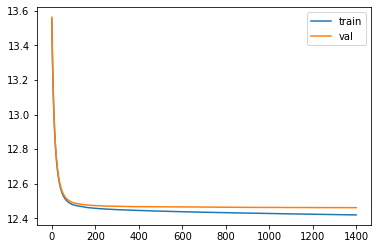

In [21]:
plt.plot(eval_result['training']['tweedie'], label = 'train')
plt.plot(eval_result['valid_1']['tweedie'], label = 'val')
plt.legend()

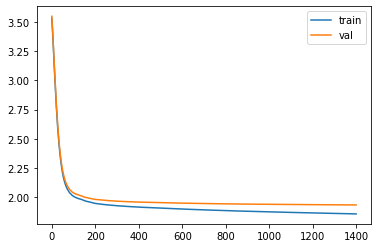

In [22]:
plt.plot(eval_result['training']['rmse'], label = 'train')
plt.plot(eval_result['valid_1']['rmse'], label = 'val')
plt.legend()

In [0]:
# plt.plot(model.evals_result_['learn']['RMSE'], label = 'train')
# plt.plot(model.evals_result_['validation']['RMSE'], label = 'val')
# plt.legend()

AttributeError: ignored

In [0]:
feature_imp = pd.DataFrame({'feature': model.feature_name(),
                            'importance': model.feature_importance('split')})

In [0]:
feature_imp = feature_imp.sort_values('importance', ascending = False)

<Figure size 1080x504 with 0 Axes>

150

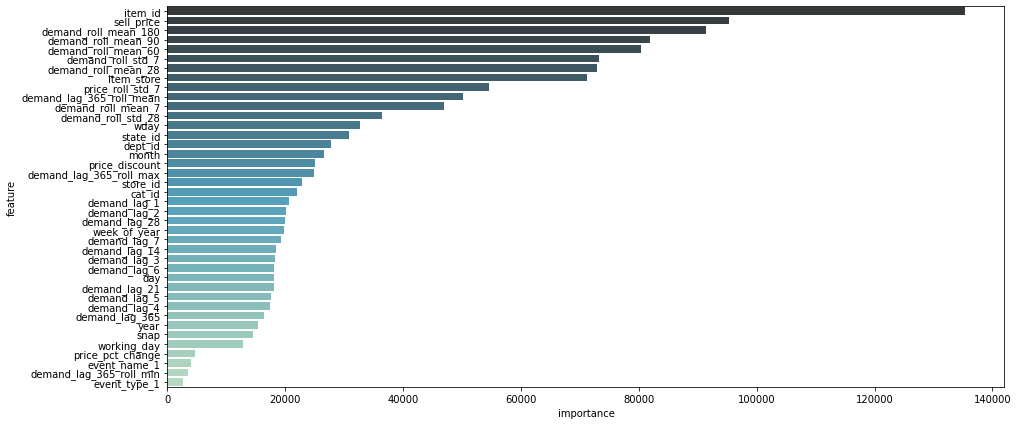

In [25]:
# feature_imp = model.get_feature_importance(prettified = True)
plt.figure(figsize = (15, 7))
sns.barplot(y = feature_imp['feature'], x = feature_imp['importance'], palette = 'GnBu_d')
gc.collect()

In [0]:
plt.figure(figsize = (5, 5))
#sns.scatterplot(val_Y, [max(0, x) for x in model.get_test_eval()], color = 'lightsteelblue')
sns.scatterplot(val_Y, model.predict(val_X), color = 'lightsteelblue')
sns.lineplot(val_Y, val_Y, color = 'indianred', lw = 0.8)

del val_Y
gc.collect()

In [0]:
# train_pred = model.predict()

In [0]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression(fit_intercept=True)

# model.fit(train_pred.reshape(-1, 1), train.get_label())

In [0]:
# model.coef_
# model.intercept_

In [0]:
# plt.figure(figsize = (5, 5))
# plt.scatter(train.get_label(), train_pred * 1.03)
# plt.plot(train.get_label(), train.get_label(), '-', color = 'red')

In [0]:
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

In [0]:
# last28_emb = get_embedding(last28[x])

In [0]:
# last28_emb = pd.DataFrame(last28_emb,
#                          index = last28.index,
#                          columns = ['emb_' + str(x) for x in range(32)])

In [0]:
# last28_X = last28[x]

In [0]:
# last28_X = last28_X.drop(columns = cat_fea)

In [0]:
# last28_X = pd.concat([last28_X, last28_emb], axis = 1)

In [0]:
# del last28_emb
# gc.collect()

7

In [0]:
# last28_X = last28_X.values.astype('float32')
# gc.collect()

0

In [27]:
submission = pd.read_csv('m5-forecasting-accuracy/sample_submission.csv')
F = submission.columns
idx = submission.id
del submission
gc.collect()

last28['demand'] = [max(0, x) for x in model.predict(last28[x])]
last28_pred = last28.pivot(index = 'id', columns = 'F', values = 'demand').reset_index()[F]
#last28_pred['id'] = (last28_pred['id'] + '_validation').astype('str')
last28_pred['id'] = pd.Categorical(last28_pred['id'], categories = idx)
last28_pred = last28_pred.sort_values(by = 'id')

gc.collect()
last28_pred

0

0

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
14370,HOBBIES_1_001_CA_1_validation,0.923808,0.857852,0.865530,0.855587,1.079306,1.144541,1.116034,0.952510,0.866691,0.764681,0.783492,0.825051,0.957194,1.038467,0.942762,0.925413,0.889201,0.817218,0.974173,1.314660,1.132043,0.859504,0.897064,0.927342,0.945347,0.975123,1.156486,1.126029
14380,HOBBIES_1_002_CA_1_validation,0.319316,0.307859,0.305937,0.345376,0.370088,0.427436,0.457735,0.223522,0.191677,0.201760,0.185819,0.242505,0.263368,0.269022,0.190324,0.161424,0.173807,0.174628,0.219523,0.285265,0.284066,0.197138,0.167027,0.180302,0.234345,0.248082,0.298077,0.255249
14390,HOBBIES_1_003_CA_1_validation,0.419461,0.348962,0.328033,0.403945,0.487833,0.566709,0.357519,0.394918,0.356956,0.325958,0.291643,0.380819,0.610311,0.489013,0.231940,0.222794,0.238106,0.296080,0.402197,0.743679,0.644105,0.461101,0.529941,0.550525,0.582045,0.590389,0.731551,0.737856
14400,HOBBIES_1_004_CA_1_validation,2.020632,1.378890,1.318406,1.881012,1.778621,3.170638,3.096295,2.151036,1.609329,1.894483,1.958983,1.983503,2.736505,2.882699,1.702458,1.488771,1.395836,1.685751,2.157742,2.984729,2.705330,1.939114,1.559154,1.405583,1.438901,1.813535,2.983465,2.699637
14410,HOBBIES_1_005_CA_1_validation,0.959598,1.072603,0.919981,1.023120,1.224845,1.439880,1.383138,1.173930,1.026645,0.980966,1.068094,1.218385,1.674329,1.653847,1.139838,1.026661,1.002414,0.956704,1.158247,1.580747,1.490509,1.065932,1.089065,1.006511,1.060637,1.106496,1.364819,1.275663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14329,FOODS_3_823_WI_3_validation,0.209277,0.193527,0.194853,0.181384,0.229748,0.193747,0.160117,0.106340,0.104683,0.099345,0.141390,0.139203,0.110664,0.183765,0.125343,0.763519,0.486362,0.452604,0.459407,0.692223,0.648516,0.424604,0.310220,0.311238,0.308263,0.456514,0.432921,0.395343
14339,FOODS_3_824_WI_3_validation,0.004545,0.006335,0.008257,0.007213,0.009469,0.133473,0.311749,0.288073,0.367407,0.315836,0.250313,0.271507,0.288067,0.243370,0.254117,0.270647,0.267773,0.278950,0.280205,0.278211,0.237850,0.169940,0.140856,0.116150,0.108847,0.117997,0.137980,0.214689
14349,FOODS_3_825_WI_3_validation,0.779574,0.628216,0.694666,0.667922,0.796371,1.011852,1.330130,0.754035,1.041800,1.002600,0.873589,1.221101,1.330155,1.303880,1.228846,1.245673,0.834852,0.954287,1.058180,1.169395,1.164557,0.947040,0.671368,0.722385,0.610630,0.794105,0.904004,0.950259
14359,FOODS_3_826_WI_3_validation,1.112315,1.130425,1.096227,0.989695,1.004625,1.102228,1.196613,1.131788,1.354771,1.371175,1.070192,1.323384,1.750610,1.460711,1.349847,1.251363,1.015542,1.233127,1.336392,1.399273,1.227288,1.041273,0.986991,0.844721,0.859157,1.016175,1.459163,1.357931


In [28]:
train_val = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')
train_fold_df = train_val.iloc[:, :-28]
valid_fold_df = train_val.iloc[:, -28:].copy()

del train_val
gc.collect()

e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)

9903

In [29]:
e.score(np.array(last28_pred.iloc[:, 1:]))

0.47361355944129674

In [0]:
del e, calendar, prices, train_fold_df, valid_fold_df, last28, last28_pred
gc.collect()

67

In [0]:
gc.collect()

0

## Predict for d_1914 ~ d_1941

In [0]:
for i in range(1914, 1942):
    tmp = sales.loc[sales.d >= i - 368, ['item_store', 'd', 'demand']] \
        .append(test.loc[test.d < i, ['item_store', 'd', 'demand']])
    idx = tmp.loc[tmp.d == i - 365, 'item_store']

    print('Imputing features for Day ' + str(i))
    if test.loc[test.d == i, 'demand_lag_1'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_1'] = list(tmp.loc[tmp.d == i - 1, 'demand'])
    if test.loc[test.d == i, 'demand_lag_2'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_2'] = list(tmp.loc[tmp.d == i - 2, 'demand'])
    if test.loc[test.d == i, 'demand_lag_3'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_3'] = list(tmp.loc[tmp.d == i - 3, 'demand'])
    if test.loc[test.d == i, 'demand_lag_4'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_4'] = list(tmp.loc[tmp.d == i - 4, 'demand'])
    if test.loc[test.d == i, 'demand_lag_5'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_5'] = list(tmp.loc[tmp.d == i - 5, 'demand'])
    if test.loc[test.d == i, 'demand_lag_6'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_6'] = list(tmp.loc[tmp.d == i - 6, 'demand'])
    if test.loc[test.d == i, 'demand_lag_7'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_7'] = list(tmp.loc[tmp.d == i - 7, 'demand'])
    if test.loc[test.d == i, 'demand_lag_14'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_14'] = list(tmp.loc[tmp.d == i - 14, 'demand'])
    if test.loc[test.d == i, 'demand_lag_21'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_21'] = list(tmp.loc[tmp.d == i - 21, 'demand'])
    if test.loc[test.d == i, 'demand_lag_28'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_28'] = list(tmp.loc[tmp.d == i - 28, 'demand'])
    if test.loc[test.d == i, 'demand_lag_365'].isnull().sum() == 30490:
        test.loc[test.d == i, 'demand_lag_365'] = list(tmp.loc[tmp.d == i - 365, 'demand'])
    if test.loc[test.d == i, 'demand_lag_365_roll_mean'].isnull().sum() == 30490:
        roll_mean = tmp.loc[(tmp.d >= i-367) & (tmp.d <= i-363), ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'mean'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_lag_365_roll_mean'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    if test.loc[test.d == i, 'demand_roll_mean_7'].isnull().sum() == 30490:
        roll_mean = tmp.loc[tmp.d >= i-7, ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'mean'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_roll_mean_7'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    if test.loc[test.d == i, 'demand_roll_mean_28'].isnull().sum() == 30490:
        roll_mean = tmp.loc[tmp.d >= i-28, ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'mean'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_roll_mean_28'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    if test.loc[test.d == i, 'demand_roll_mean_60'].isnull().sum() == 30490:
        roll_mean = tmp.loc[tmp.d >= i-60, ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'mean'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_roll_mean_60'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    if test.loc[test.d == i, 'demand_roll_mean_90'].isnull().sum() == 30490:
        roll_mean = tmp.loc[tmp.d >= i-90, ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'mean'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_roll_mean_90'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    if test.loc[test.d == i, 'demand_roll_mean_180'].isnull().sum() == 30490:
        roll_mean = tmp.loc[tmp.d >= i-180, ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'mean'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_roll_mean_180'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    if test.loc[test.d == i, 'demand_roll_std_7'].isnull().sum() == 30490:
        roll_mean = tmp.loc[tmp.d >= i-7, ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'std'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_roll_std_7'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    if test.loc[test.d == i, 'demand_roll_std_28'].isnull().sum() == 30490:
        roll_mean = tmp.loc[tmp.d >= i-28, ['item_store', 'd', 'demand']] \
            .groupby('item_store').agg({'demand': 'std'}).reset_index()
        roll_mean['item_store'] = pd.Categorical(roll_mean['item_store'], categories = idx)
        roll_mean = roll_mean.sort_values(by = 'item_store')
        test.loc[test.d == i, 'demand_roll_std_28'] = list(roll_mean['demand'])

        del roll_mean
        gc.collect()

    print('Predicting for Day ' + str(i))
    # test_X = test.loc[test.d == i, x]
    # test_emb = get_embedding(test_X)
    # test_emb = pd.DataFrame(test_emb,
    #                         index = test_X.index,
    #                         columns = ['emb_' + str(x) for x in range(32)])
    # test_X = test_X.drop(columns = cat_fea)
    # test_X = pd.concat([test_X, test_emb], axis = 1)
    # del test_emb

    pred = model.predict(test.loc[test.d == i, x])
    pred = [max(0, x) for x in pred]
    test.loc[test.d == i, 'demand'] = pred

Imputing features for Day 1914
Predicting for Day 1914
Imputing features for Day 1915


4

0

0

0

0

0

0

Predicting for Day 1915
Imputing features for Day 1916


4

0

0

0

0

0

0

Predicting for Day 1916
Imputing features for Day 1917


4

0

0

0

0

0

0

Predicting for Day 1917
Imputing features for Day 1918


4

0

0

0

0

0

0

Predicting for Day 1918
Imputing features for Day 1919


4

0

0

0

0

0

0

Predicting for Day 1919
Imputing features for Day 1920


4

0

0

0

0

0

0

Predicting for Day 1920
Imputing features for Day 1921


4

0

0

0

0

0

0

Predicting for Day 1921
Imputing features for Day 1922


4

0

0

0

0

0

0

Predicting for Day 1922
Imputing features for Day 1923


4

0

0

0

0

0

0

Predicting for Day 1923
Imputing features for Day 1924


4

0

0

0

0

0

0

Predicting for Day 1924
Imputing features for Day 1925


4

0

0

0

0

0

0

Predicting for Day 1925
Imputing features for Day 1926


4

0

0

0

0

0

0

Predicting for Day 1926
Imputing features for Day 1927


4

0

0

0

0

0

0

Predicting for Day 1927
Imputing features for Day 1928


4

0

0

0

0

0

0

Predicting for Day 1928
Imputing features for Day 1929


4

0

0

0

0

0

0

Predicting for Day 1929
Imputing features for Day 1930


4

0

0

0

0

0

0

Predicting for Day 1930
Imputing features for Day 1931


4

0

0

0

0

0

0

Predicting for Day 1931
Imputing features for Day 1932


4

0

0

0

0

0

0

Predicting for Day 1932
Imputing features for Day 1933


4

0

0

0

0

0

0

Predicting for Day 1933
Imputing features for Day 1934


4

0

0

0

0

0

0

Predicting for Day 1934
Imputing features for Day 1935


4

0

0

0

0

0

0

Predicting for Day 1935
Imputing features for Day 1936


4

0

0

0

0

0

0

Predicting for Day 1936
Imputing features for Day 1937


4

0

0

0

0

0

0

Predicting for Day 1937
Imputing features for Day 1938


4

0

0

0

0

0

0

Predicting for Day 1938
Imputing features for Day 1939


4

0

0

0

0

0

0

Predicting for Day 1939
Imputing features for Day 1940


4

0

0

0

0

0

0

Predicting for Day 1940
Imputing features for Day 1941


4

0

0

0

0

0

0

Predicting for Day 1941


In [0]:
submission = test.pivot(index = 'id',columns = 'F', values = 'demand').reset_index()[F]
submission = submission.fillna(0)

In [0]:
submission

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,FOODS_1_001_CA_1_validation,1.117542,0.974630,0.864488,0.975454,1.200362,1.157944,1.047503,0.863337,0.853926,0.861701,0.803615,0.931787,1.113344,0.938943,0.826408,0.793830,0.783569,0.832049,0.907943,1.045840,0.984760,0.765364,0.694974,0.692034,0.741129,0.872786,0.958438,0.944721
2,FOODS_1_001_CA_2_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,FOODS_1_001_CA_2_validation,1.007938,1.326474,1.428665,1.400485,1.576524,1.870998,1.992993,1.369758,1.436495,1.337327,1.347743,1.615458,2.100714,2.022801,1.643313,1.618560,1.554270,1.539404,1.795691,2.123077,2.094283,1.198443,1.239985,1.140892,1.207754,1.453463,1.783015,1.903451
4,FOODS_1_001_CA_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_WI_1_validation,0.093414,0.087035,0.097576,0.108146,0.129180,0.134666,0.121032,0.105401,0.106160,0.106489,0.118844,0.123279,0.167158,0.140604,0.089671,0.092004,0.088435,0.092453,0.104142,0.116397,0.094788,0.076648,0.075520,0.074854,0.085469,0.108680,0.123377,0.114085
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,HOUSEHOLD_2_516_WI_2_validation,0.081029,0.075599,0.093279,0.104219,0.106473,0.134673,0.113277,0.118126,0.110720,0.103672,0.100702,0.108225,0.146691,0.124167,0.099550,0.102171,0.096281,0.109007,0.105700,0.132968,0.111220,0.093935,0.094360,0.101907,0.094481,0.103395,0.097689,0.093267
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
submission.to_csv('submission_0430_1.csv', index = False)